In [3]:
import pandas as pd
import pymysql.cursors
from SqlCommand import SqlCommand

cnx = pymysql.connect(user='root',
                      password='',
                      host='127.0.0.1',
                      charset='utf8mb4',
                      database='btplenar')

si = SqlCommand(cnx)

query = """SELECT rede.idrede, MdB.idmdb, MdB.Vorname, MdB.Nachname, mdb.geschlecht, absatz.text, absatz.idabsatz, fraktion.name_kurz, mandat.art,
SUM(LENGTH(absatz.text) - LENGTH(REPLACE(absatz.text, ' ', '')) + 1) as woerter
FROM absatz
LEFT JOIN (Rede, MdB, Mandat, Fraktion, Tagesordnungspunkt, sitzung) 
ON (Rede.idRede = Absatz.Rede 
AND Tagesordnungspunkt.idTagesordnungspunkt = Rede.top
AND sitzung.idSitzung = Tagesordnungspunkt.sitzung
AND Rede.redner = MdB.idMdB
AND Mandat.MdB = MdB.idMdB
AND fraktion.idfraktion = mandat.fraktion)
WHERE Rede.kurzintervention is null
AND Rede.antwort_kurzintervention is null
AND mandat.bis is NULL
AND mandat.wahlp = 19
AND rede.mitRolle is NULL
AND (SELECT COUNT(*) 
FROM absatz 
LEFT JOIN rede as r
ON (r.idRede = Absatz.rede)
Where r.idRede = rede.idRede) > 3
group by rede.idrede;"""


raw_data = si.query(query)
df = pd.DataFrame([raw_data[key] for key in raw_data])
df.dropna(inplace=True)
df['woerter'] = df['woerter'].astype(int)

InternalError: (1055, "Expression #6 of SELECT list is not in GROUP BY clause and contains nonaggregated column 'btplenar.absatz.Text' which is not functionally dependent on columns in GROUP BY clause; this is incompatible with sql_mode=only_full_group_by")

In [141]:
df.groupby(['geschlecht', 'name_kurz'])['woerter'].agg('mean').unstack().fillna('-').round(2)

name_kurz      AfD  CDU/CSU     FDP   GRÜNE   LINKE     SPD  fraktionslos
geschlecht                                                               
männlich    632.54   719.39  606.97  634.60  632.20  682.49        368.00
weiblich    595.48   761.25  556.07  670.11  593.62  644.41        349.64

In [133]:
df.groupby(['geschlecht', 'art', 'name_kurz'])['idmdb'].agg('count').unstack()

name_kurz                 AfD  CDU/CSU    FDP  GRÜNE  LINKE   SPD  \
geschlecht art                                                      
männlich   Direktwahl     4.0    367.0    NaN    NaN    6.0  92.0   
           Landesliste  175.0     18.0  148.0   67.0   68.0  95.0   
weiblich   Direktwahl     NaN     59.0    NaN    3.0    4.0  33.0   
           Landesliste   20.0     13.0   44.0  100.0   97.0  92.0   

name_kurz               fraktionslos  
geschlecht art                        
männlich   Direktwahl            NaN  
           Landesliste           7.0  
weiblich   Direktwahl            8.0  
           Landesliste           NaN

In [1]:
import pandas as pd
from scipy import stats
from math import log
import seaborn as sns
import pymysql.cursors
from SqlCommand import SqlCommand

cnx = pymysql.connect(user='root',
                      password='',
                      host='127.0.0.1',
                      charset='utf8mb4',
                      database='btplenar')

si = SqlCommand(cnx)

query = """SELECT absatz.`Text`, fraktion.name_kurz
        FROM absatz
        LEFT JOIN (rede, mdb, mandat, fraktion) 
        ON (rede.idrede = absatz.rede 
        AND mdb.idMdB = rede.redner
        AND mandat.mdb = mdb.idMdB
        AND fraktion.idFraktion = mandat.fraktion)
        WHERE Rede.kurzintervention is null
        AND mandat.wahlp = 19;"""

raw_data = si.query(query)

In [22]:
bag_o_words = {}
for elem in raw_data.values():
    if elem['Text'] is None:
        continue
    if elem['name_kurz'] not in bag_o_words:
        bag_o_words[elem['name_kurz']] = {}
    for char in ',.!"\'§$%&/()=}{[]*-°}':
        elem['Text'] = elem['Text'].replace(char, '')
    for word in elem['Text'].split(' ')[1:]:
        if len(word) < 4 or word[0].islower():
            continue
        if word not in bag_o_words[elem['name_kurz']]:
            bag_o_words[elem['name_kurz']][word] = 1
        else:
            bag_o_words[elem['name_kurz']][word] += 1
    

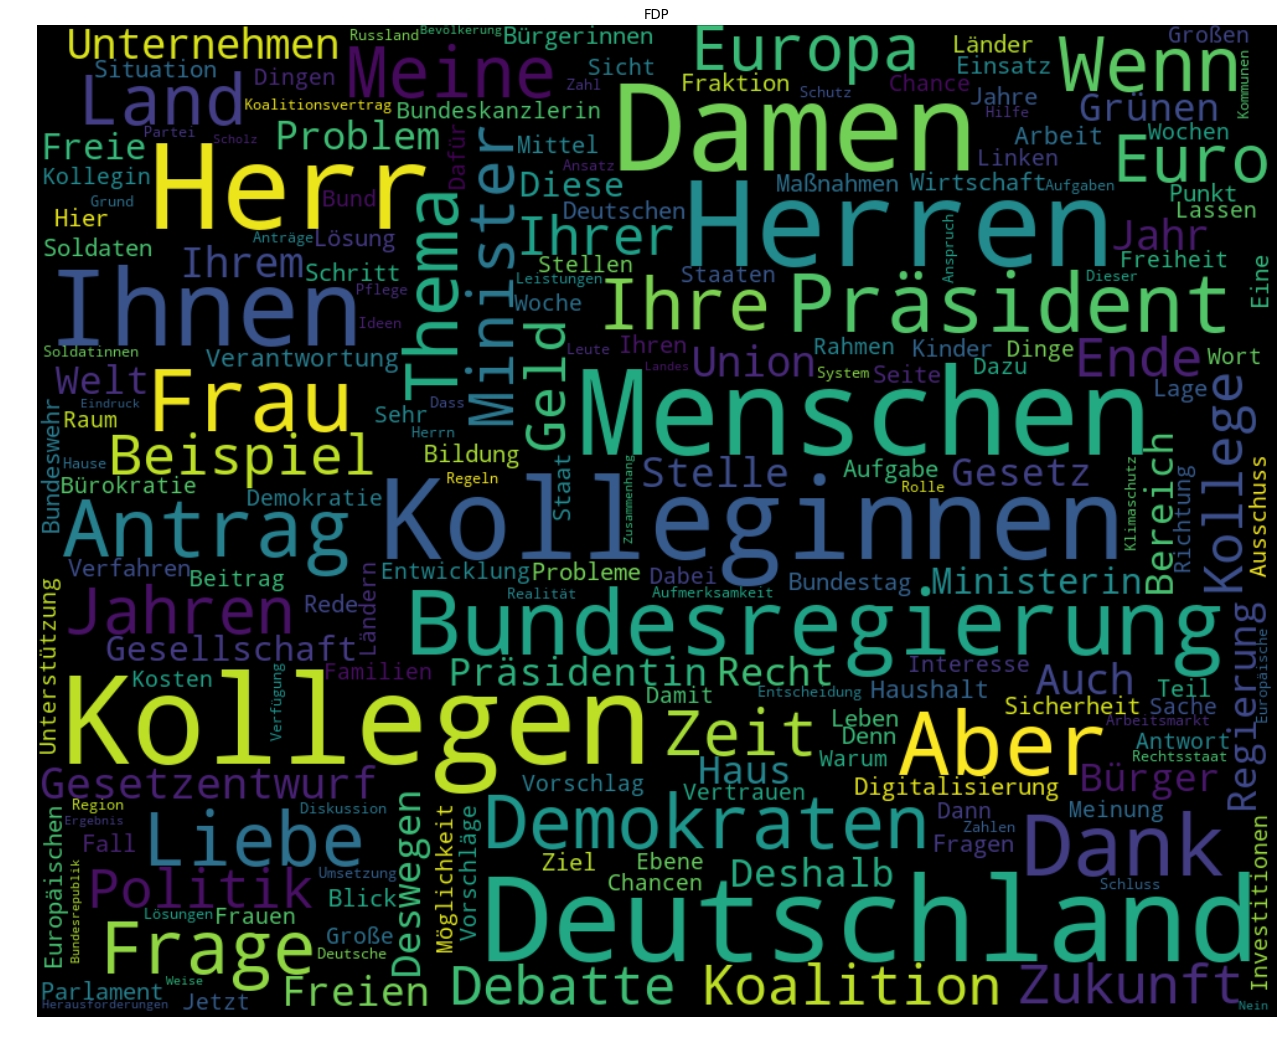

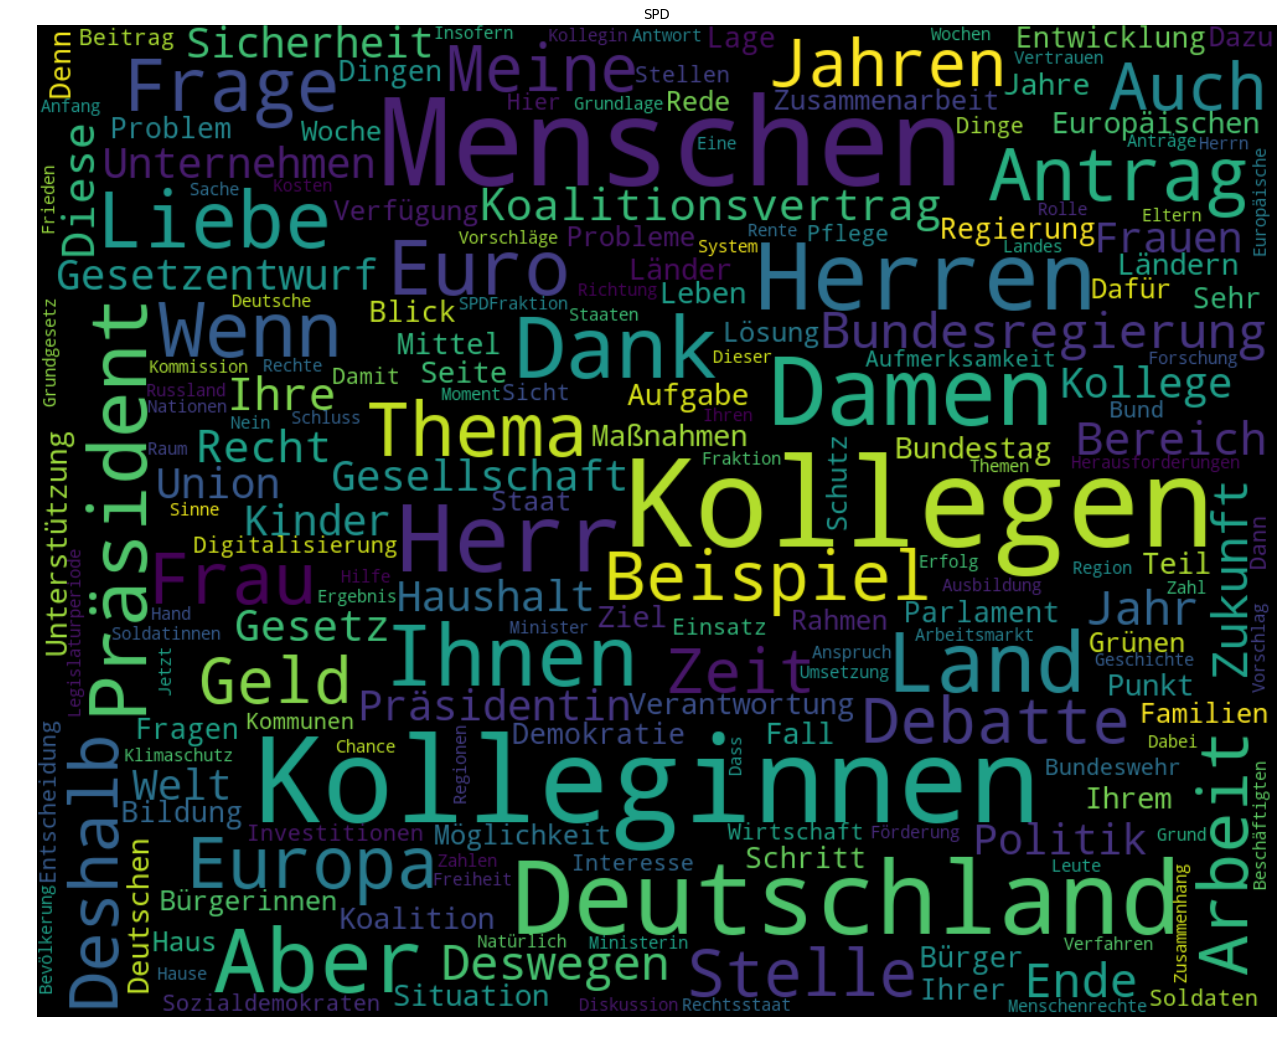

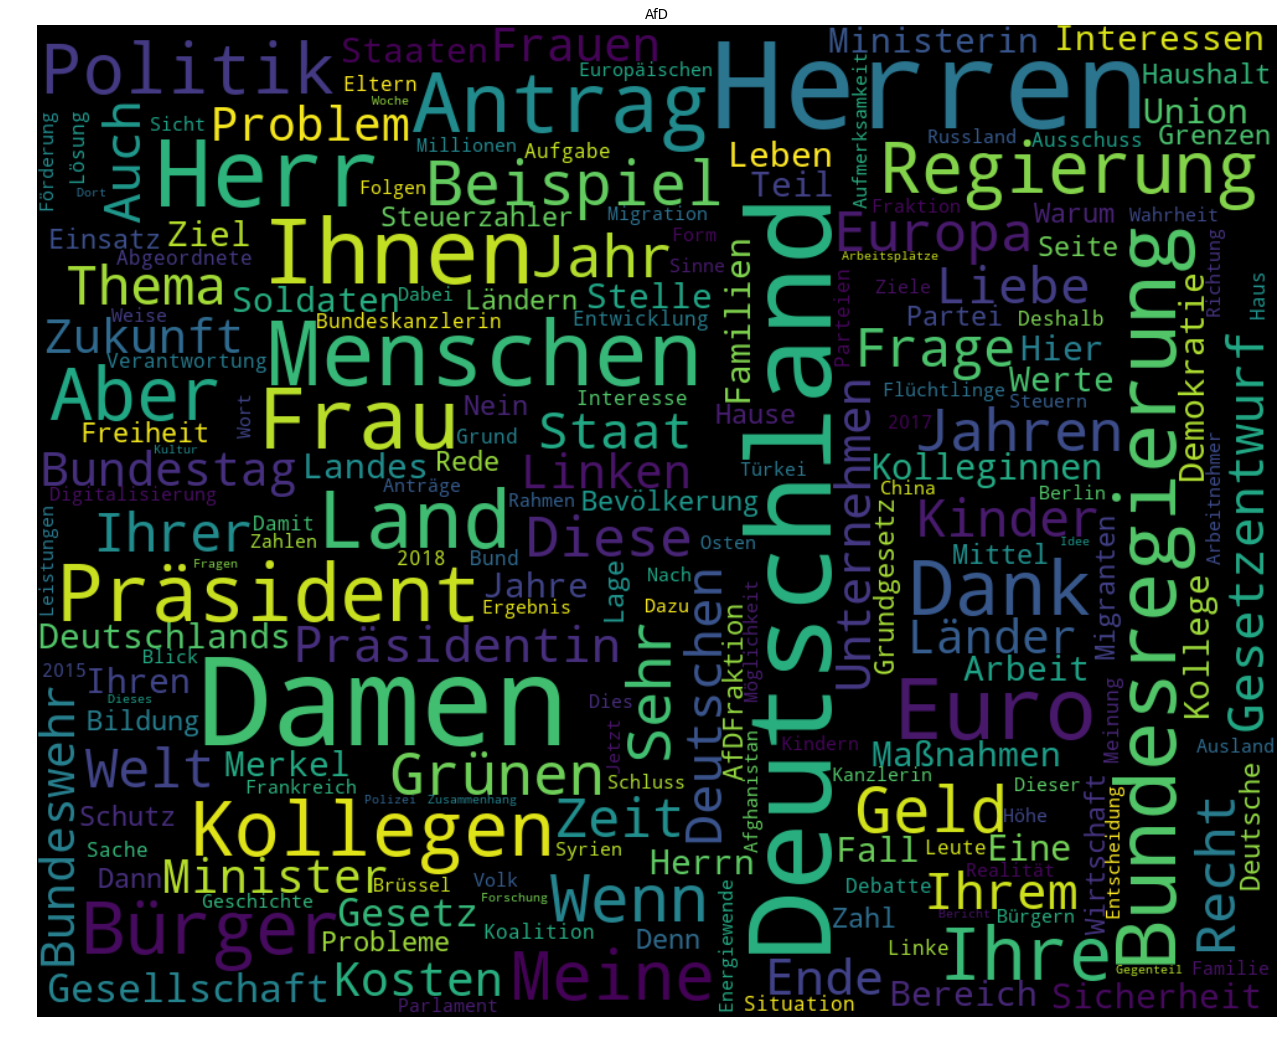

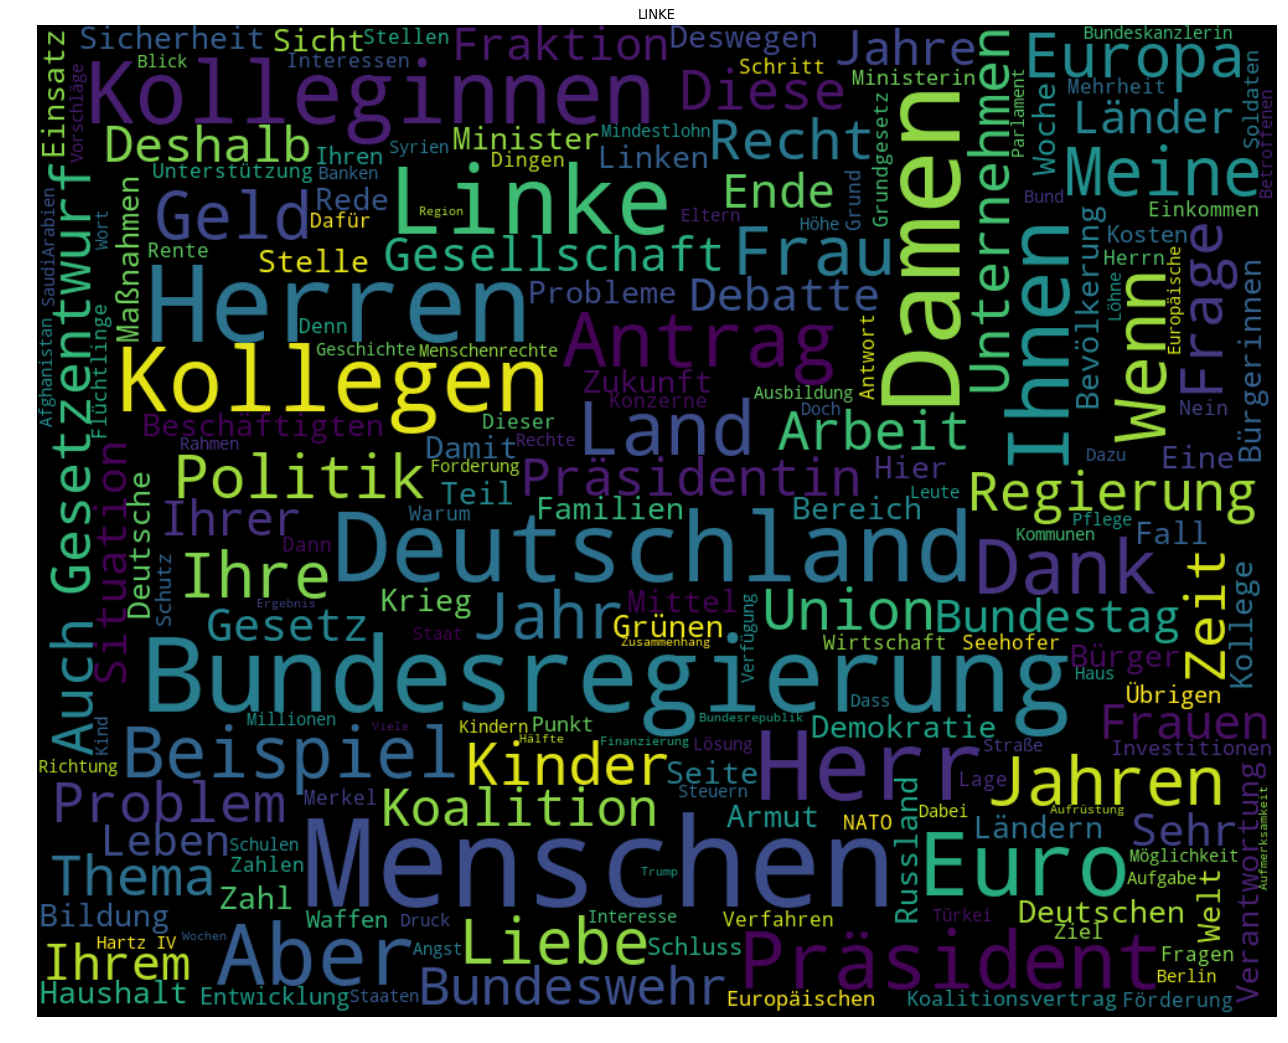

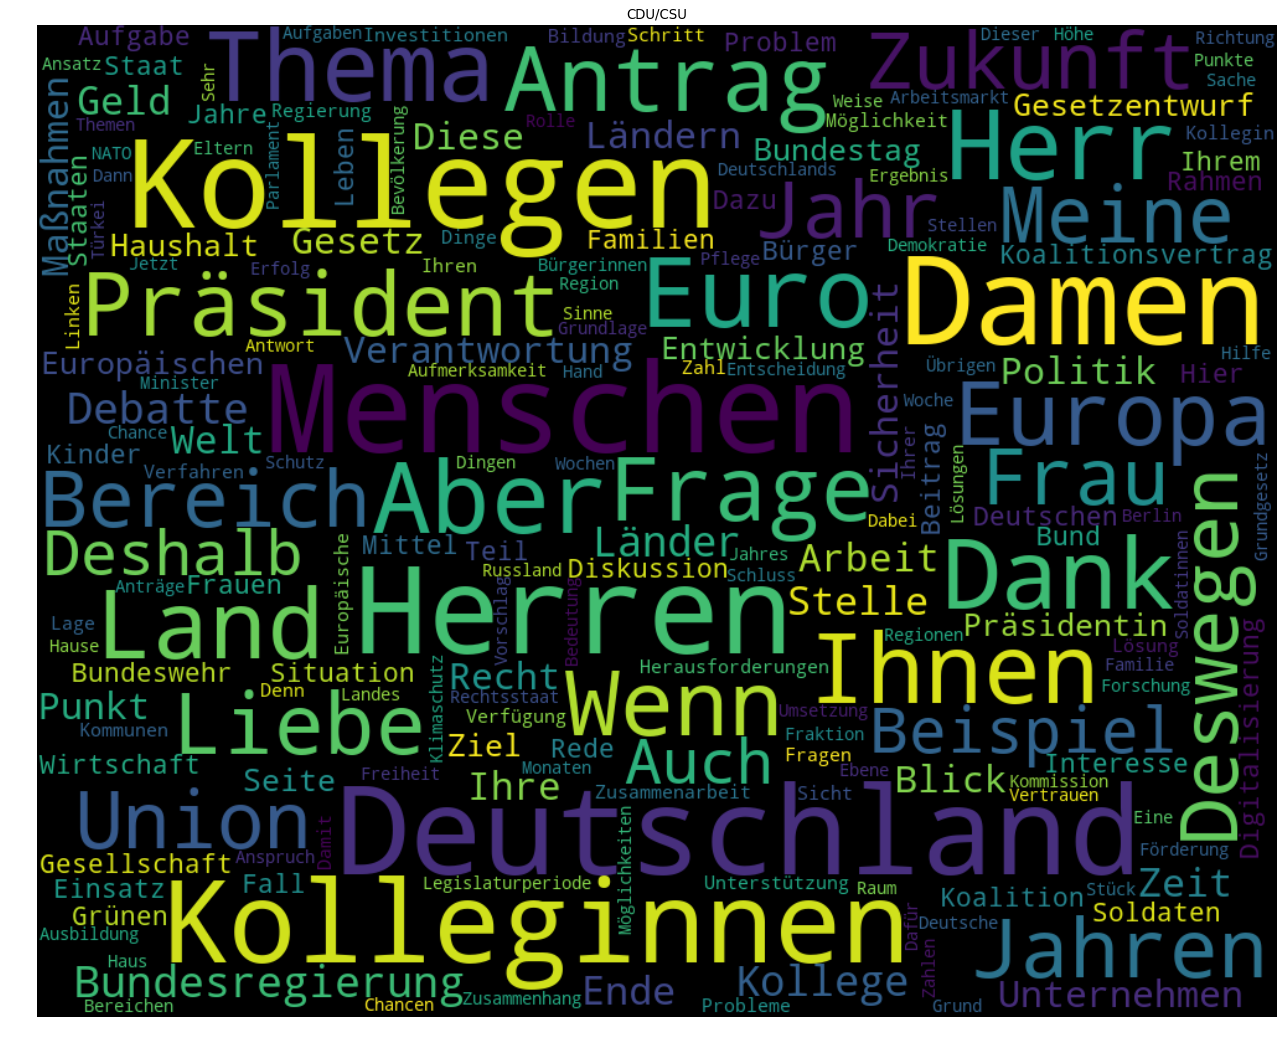

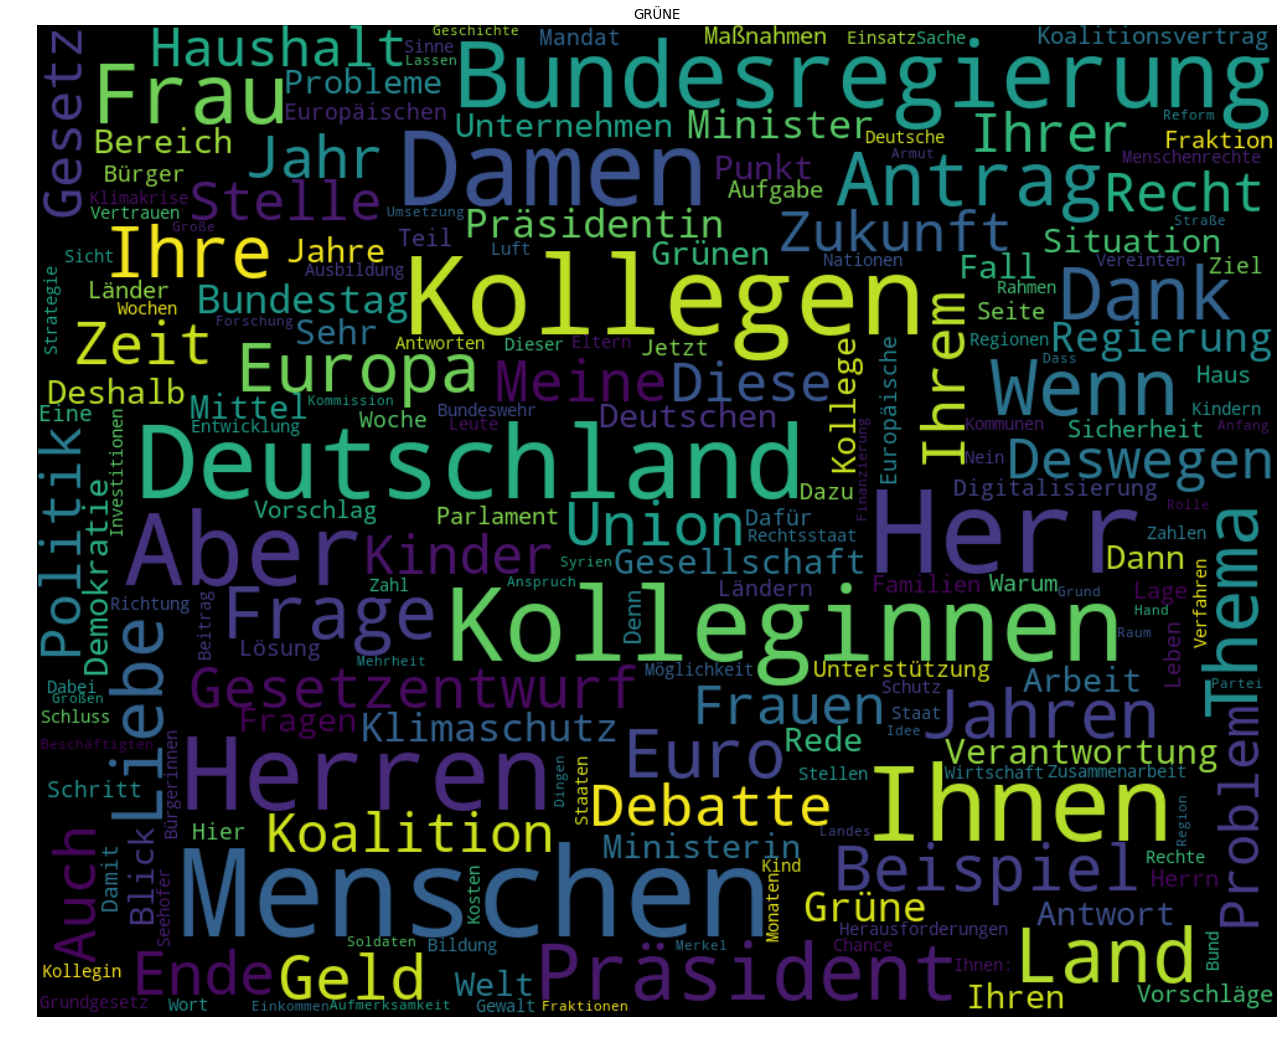

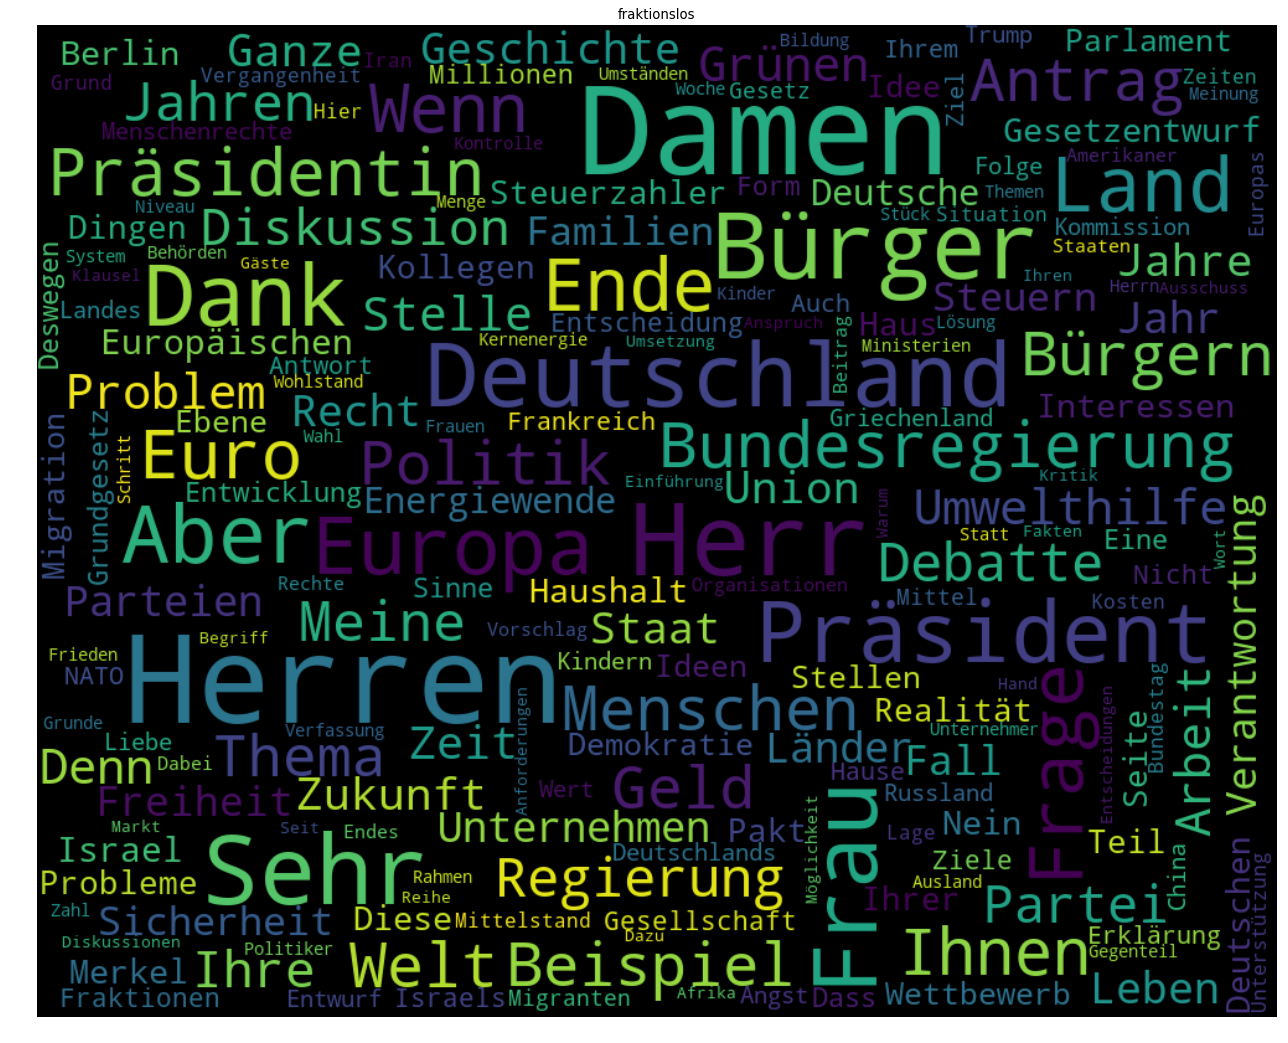

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for k, v in bag_o_words.items():
    wordcloud = WordCloud(max_font_size=100, max_words=200, width=1000, height=800).generate_from_frequencies(v)
    plt.figure(figsize=(20,30), dpi= 80)
    plt.title(k)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'{k.replace("/", "")}.jpg')

[('Kollegen', 1657),
 ('Damen', 1601),
 ('Herren', 1583),
 ('Menschen', 1573),
 ('Herr', 1538),
 ('Deutschland', 1505),
 ('Kolleginnen', 1364),
 ('Ihnen', 1182),
 ('Bundesregierung', 1026),
 ('Aber', 972),
 ('Frau', 958),
 ('Dank', 938),
 ('Präsident', 851),
 ('Antrag', 833),
 ('Wenn', 721),
 ('Liebe', 700),
 ('Demokraten', 696),
 ('Frage', 677),
 ('Thema', 676),
 ('Ihre', 653),
 ('Meine', 633),
 ('Land', 616),
 ('Euro', 556),
 ('Jahren', 536),
 ('Minister', 511),
 ('Europa', 510),
 ('Zeit', 502),
 ('Beispiel', 484),
 ('Geld', 480),
 ('Koalition', 473),
 ('Kollege', 454),
 ('Ende', 446),
 ('Politik', 446),
 ('Debatte', 439),
 ('Ihrer', 433),
 ('Zukunft', 428),
 ('Gesetzentwurf', 423),
 ('Auch', 409),
 ('Ihrem', 406),
 ('Jahr', 402),
 ('Union', 402),
 ('Unternehmen', 391),
 ('Stelle', 378),
 ('Freien', 375),
 ('Problem', 363),
 ('Regierung', 362),
 ('Recht', 358),
 ('Deswegen', 350),
 ('Bürger', 339),
 ('Welt', 335),
 ('Bereich', 329),
 ('Präsidentin', 328),
 ('Haus', 319),
 ('Grünen', 

In [12]:
sorted(bag_o_words['GRÜNE'].items(), key=lambda kv: kv[1], reverse=True)

[('Menschen', 1681),
 ('Herr', 1474),
 ('Kollegen', 1281),
 ('Damen', 1179),
 ('Ihnen', 1168),
 ('Herren', 1154),
 ('Kolleginnen', 1146),
 ('Deutschland', 1117),
 ('Aber', 1082),
 ('Bundesregierung', 1051),
 ('Frau', 862),
 ('Wenn', 767),
 ('Präsident', 757),
 ('Land', 712),
 ('Antrag', 699),
 ('Frage', 676),
 ('Thema', 669),
 ('Dank', 668),
 ('Ihre', 630),
 ('Liebe', 623),
 ('Europa', 590),
 ('Euro', 590),
 ('Jahren', 578),
 ('Beispiel', 506),
 ('Geld', 485),
 ('Union', 473),
 ('Ende', 471),
 ('Ihrem', 457),
 ('Zeit', 445),
 ('Jahr', 442),
 ('Auch', 426),
 ('Debatte', 423),
 ('Meine', 416),
 ('Gesetzentwurf', 410),
 ('Zukunft', 390),
 ('Deswegen', 383),
 ('Politik', 381),
 ('Koalition', 368),
 ('Stelle', 368),
 ('Kinder', 367),
 ('Ihrer', 365),
 ('Diese', 361),
 ('Problem', 356),
 ('Gesetz', 352),
 ('Recht', 350),
 ('Frauen', 349),
 ('Haushalt', 344),
 ('Regierung', 342),
 ('Grüne', 333),
 ('Klimaschutz', 322),
 ('Minister', 316),
 ('Präsidentin', 307),
 ('Bundestag', 300),
 ('Verantw

In [14]:
import pandas as pd
df = pd.DataFrame({})
for frak in bag_o_words.keys():
    bow = sorted(bag_o_words[frak].items(), key=lambda kv: kv[1], reverse=True)
    words = ['AfD', 'Liebe', 'Euro', 'Geld', 'Frieden', 'Freiheit', 'Gerechtigkeit', 'Sicherheit', 'SPD', 'CDU', 'Grünen', 'Nazi', 'Wir', 'Krise', 'Krieg', 'Klima', 'Miete', 'Steuern', 'Waffen']
    stats = {}
    stats['Fraktion'] = frak
    for word in words:
        stats[word] = -1
    for i, (k,v) in enumerate(bow):
        for word in words:
            if word == k:
                stats[word] = i
    df = df.append(stats, ignore_index=True)
    print(f'{(" ").join([str(k) + ":" + str(v) for k,v in stats.items()])} {frak}')
#sorted(bag_o_words['AfD'].items(), key=lambda kv: kv[1], reverse=True)

Fraktion:FDP AfD:70 Liebe:22 Euro:29 Geld:37 Frieden:249 Freiheit:146 Gerechtigkeit:1318 Sicherheit:86 SPD:56 CDU:264 Grünen:68 Nazi:11711 Wir:2 Krise:667 Krieg:499 Klima:531 Miete:1959 Steuern:405 Waffen:1611 FDP
Fraktion:SPD AfD:47 Liebe:18 Euro:20 Geld:36 Frieden:208 Freiheit:201 Gerechtigkeit:470 Sicherheit:62 SPD:40 CDU:489 Grünen:113 Nazi:12305 Wir:2 Krise:543 Krieg:548 Klima:680 Miete:617 Steuern:306 Waffen:742 SPD
Fraktion:AfD AfD:14 Liebe:54 Euro:12 Geld:30 Frieden:283 Freiheit:113 Gerechtigkeit:483 Sicherheit:94 SPD:37 CDU:132 Grünen:35 Nazi:4334 Wir:6 Krise:665 Krieg:448 Klima:411 Miete:1691 Steuern:184 Waffen:520 AfD
Fraktion:LINKE AfD:25 Liebe:31 Euro:14 Geld:29 Frieden:305 Freiheit:364 Gerechtigkeit:470 Sicherheit:101 SPD:42 CDU:254 Grünen:121 Nazi:-1 Wir:3 Krise:353 Krieg:106 Klima:477 Miete:607 Steuern:195 Waffen:127 LINKE
Fraktion:CDU/CSU AfD:59 Liebe:25 Euro:16 Geld:46 Frieden:240 Freiheit:160 Gerechtigkeit:862 Sicherheit:58 SPD:174 CDU:377 Grünen:92 Nazi:-1 Wir:1 Kri

In [15]:
df

AfD    CDU  Euro      Fraktion  Freiheit  Frieden  Geld  Gerechtigkeit  \
0   70.0  264.0  29.0           FDP     146.0    249.0  37.0         1318.0   
1   47.0  489.0  20.0           SPD     201.0    208.0  36.0          470.0   
2   14.0  132.0  12.0           AfD     113.0    283.0  30.0          483.0   
3   25.0  254.0  14.0         LINKE     364.0    305.0  29.0          470.0   
4   59.0  377.0  16.0       CDU/CSU     160.0    240.0  46.0          862.0   
5   40.0  246.0  29.0         GRÜNE     297.0    243.0  34.0          505.0   
6  332.0  138.0  21.0  fraktionslos      77.0    199.0  34.0           -1.0   

   Grünen  Klima  Krieg  Krise  Liebe   Miete     Nazi    SPD  Sicherheit  \
0    68.0  531.0  499.0  667.0   22.0  1959.0  11711.0   56.0        86.0   
1   113.0  680.0  548.0  543.0   18.0   617.0  12305.0   40.0        62.0   
2    35.0  411.0  448.0  665.0   54.0  1691.0   4334.0   37.0        94.0   
3   121.0  477.0  106.0  353.0   31.0   607.0     -1.0   42.0       101.0   
4    92.0  561.0  547.0  865.0   25.0  1819.0     -1.0  174.0        58.0   
5    83.0  331.0  345.0  432.0   26.0  1792.0  23670.0   62.0       118.0   
6    52.0  959.0  808.0  739.0  139.0  2340.0     -1.0   76.0        83.0   

   Steuern  Waffen  Wir  
0    405.0  1611.0  2.0  
1    306.0   742.0  2.0  
2    184.0   520.0  6.0  
3    195.0   127.0  3.0  
4    524.0   788.0  1.0  
5    378.0   467.0  2.0  
6     81.0    -1.0  5.0